In [1]:
import sqlite3
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import string
import spacy
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import time
import scipy.sparse
from gensim import matutils,models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk import pos_tag
import time
import numpy as np
import multiprocess as mp
import warnings
warnings.filterwarnings("ignore")

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Connecting to the sqlite database and fetching all the data
conn = sqlite3.connect("C:/Users/pares/Downloads/18_2157_compressed_database.sqlite/database.sqlite")
data = pd.read_sql_query(""" 
SELECT *
FROM Reviews
""",conn)

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568454 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568454 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### About the data

- We have a total of 568,454 reviews. The data has been collected from Oct 1999-Oct 2012. All we know is, these reviews are about Food products available at Amazon. Looking at the data, we can use the Summary and Text fields to understand more about what the reviews are about.

- Lets perform "Topic Modelling" on the reviews, and learn the different topics, that can help us categorize these reviews further.

- There doesn't seem to be any missing values here. The Id column is not originally present in the data on the website. This must be added later on, to make it a SQL database. 

- Columns other than Summary and Text are not relevant for this project since, we only require the textual reviews to learn about the "topics" present in the data.


In [320]:
#Lets start understanding more the data and clean it in the process
clean_data = data.drop(columns = ["Id"])

## Data Exploration

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: Text, dtype: float64

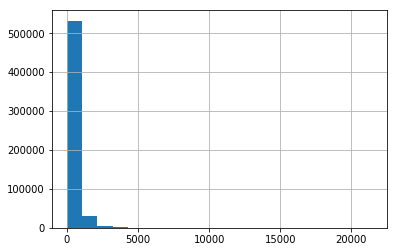

In [44]:
#How long are our reviews?
clean_data.Text.apply(len).hist(bins =20)
clean_data.Text.apply(len).describe()

Mostly, reviews extend from a few lines to short paragraphs. There are a few very long reviews that might extend to several pages.

In [15]:
#Longest review
import textwrap as tw
tw.wrap(clean_data.loc[clean_data.Text.apply(len).idxmax(clean_data.Text.apply(len))].Text,width =150)

["Fuzzy Wuzzy's Summary:<br />*** Somewhat recommended, with reservations and only lukewarm fuzzies.<br /><br />Positives:<br /><br />+ Not too",
 "expensive compared to other bottled water, although it is not cheap either.<br /><br />Negatives:<br /><br />- This bottled water product's labeling,",
 'product descriptions, and health claims are misleading.<br /><br />At first glance, this 1.5-liter bottle of water that I am reviewing looks like',
 'another one of the many varieties of bottled water on the market.  There are many kinds of bottled water: "spring water" produced from an underground',
 'formation where the groundwater naturally flows up to the Earth\'s surface, "artesian water" obtained from a well that taps into an underground',
 'aquifer, "mineral water" produced from a well or spring that naturally contains trace amounts of minerals that some people consider to provide health',
 'benefits, "ground/well water" produced from a well that tapes into an aquifer, "sparkling wa

- I see a lot of line breakers read in as text. We need to deal with this. Also, there appears words that use appostrophe. Such words will create a problem later on. We need to take care of such words early.

#### Duplicated Values

In [45]:
clean_data.duplicated().sum()

281

We have around 281 duplicated reviews. Since, we dont have a unique identifer in the dataset, lets use userID, time, summary and text to identify all the dupicated entries in the dataset.

In [49]:
clean_data[["UserId","ProfileName","Time","Summary","Text"]].duplicated().sum()

173282

Woah! Thats quite a lot of duplicated reviews. Almost 30% of our reviews are duplicated. We need to remove these reviews in order to indentify the true topics in the data.

In [321]:
clean_data = clean_data[["UserId","ProfileName","Time","Summary","Text"]]
clean_data.shape

(568454, 5)

In [322]:
clean_data.drop_duplicates(inplace = True)

In [66]:
clean_data.shape

(395172, 5)

In [69]:
#sanity check
clean_data.head()

,UserId,ProfileName,Time,Summary,Text
0,A3SGXH7AUHU8GW,delmartian,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,dll pa,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,A395BORC6FGVXV,Karl,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Cleaning text data

- We noticed a lot of html tags and grammer contractions in the text - removing them

In [290]:
#correcting grammar contractions
grammer = {"can't": "can not","won't": " will not","n't":" not", "'s":" is","'ve":" have","'re":" are","'ll":" will","'m":" am","'d":" had"}

In [285]:
#removing html tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [291]:
#function to remove html tags and replace grammer contractions from text
def clean_review(text):
    text = remove_tags(text)
    for key in grammer.keys():
        text = text.replace(key,grammer[key])
    return text

In [344]:
start = time.time()
clean_data.Text = clean_data.Text.apply(clean_review)
clean_data.Summary = clean_data.Summary.apply(clean_review)
end = time.time()
#time taken to remove non-frequent words
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total time taken to clean","{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Total time taken to clean 00:00:03.98


In [345]:
#sanity check
clean_data.head()

,UserId,ProfileName,Time,Summary,Text
0,A3SGXH7AUHU8GW,delmartian,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,dll pa,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,A395BORC6FGVXV,Karl,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Unique Words

In [347]:
#How many unique words are there?
import itertools
words = list(itertools.chain(*list(clean_data.Text.apply(word_tokenize))))
len(set(words))

355205

Right now, we have 355,205 unique tokens. But this also includes punctuations and other stopwords.

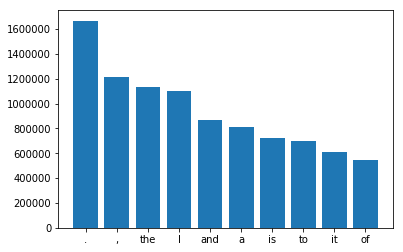

In [348]:
import operator
sorted_words = {k:v for k,v in sorted(Counter(words).items(),key = operator.itemgetter(1),reverse = True)}
plt.bar(list(itertools.islice(sorted_words.keys(),10)),list(itertools.islice(sorted_words.values(),10)))
plt.show()

As expected, the most frequent words are punctuations and stop-words. Lets further clean our reviews.

## Data Cleaning

- There are few cleaning steps that we will perform before moving forward on our reviews:
  1. Lower-case the text
  2. Remove numbers
  3. Remove extra white-spaces(if any)
  4. Remove Punctuation
  5. Tokenize reviews
  6. Remove Stop-words
  7. Lemmatize all words (I prefer lemmatizing instead of stemming - in my final topics, I need coherent words, and not just random words)
  
  
* For stop-words, we will be using an iterative list, which we will begin with an extra long list of stop-words from rank.nl (around 600 words), and then keep on adding domain specific terms as and when we counter through building initial topic models.
* We will also create and consider bi-grams and tri-grams in our model to get the best possible set of topics.

In [349]:
#loading spacy -en
nlp = spacy.load(r'C:\Users\pares\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.1.0', disable=['parser', 'ner'])

#function to clean the reviews
def clean_text(text):
    text = text.lower() #lower-casing
    text = [i for i in word_tokenize(text) if i not in stop_words] #remvoving stop-words
    doc = nlp(' '.join(text))
    text = [token.lemma_ for token in doc] #lemmatizing the reviews
    text = ' '.join(text)    
    text = re.sub(r'\d+','',text) #removing numbers
    text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text = text.strip() #removing white-spaces
    return text

In [376]:
#Initial list of stop-words (from rank.nl)
stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","different","do","does","doing","done","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","have","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","it","itd","its","itself","j","just","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","shes","should","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure","t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","thats","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","thereof","therere","theres","thereto","thereupon","these","they","theyd","theyre","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","went","were","werent","we've","what","whatever","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","your","youre","yours","yourself","yourselves","z","zero"]


In [356]:
#before moving forward, I want to keep only the columns that I will be using from here on 
clean_data.drop(["UserId","ProfileName","Time"],inplace = True,axis = 1)
clean_data.reset_index(inplace = True)
clean_data.columns = ["id","title","review"]

In [367]:
#sanity check
clean_data.head()

,id,title,review
0,0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,Cough Medicine,If you are looking for the secret ingredient i...
4,4,Great taffy,Great taffy at a great price. There was a wid...


In [370]:
#saving the cleaned reviews
clean_data.to_pickle('clean_data_original.pkl')

In [371]:
#function to input the cleaning function to multi-core processing
def clean_apply(df):
    from nltk.tokenize import word_tokenize
    import re
    import spacy
    import string

    stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep",	"keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure",	"t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero"]
    nlp = spacy.load(r'C:\Users\pares\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.1.0', disable=['parser', 'ner'])
    
    def clean_text(text):
        text = text.lower() #lower-casing
        text = [i for i in word_tokenize(text) if i not in stop_words] #remvoving stop-words
        doc = nlp(' '.join(text))
        text = [token.lemma_ for token in doc] #lemmatizing the reviews
        text = ' '.join(text)    
        text = re.sub(r'\d+','',text) #removing numbers
        text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
        text = text.strip() #removing white-spaces
        return text
    df['review'] = df.review.apply(clean_text)
    return df

In [372]:
#function to perform data cleaning using parallel processing
start = time.time()

def parallelize(dataframe,func):
    dataframe_split = np.array_split(dataframe,partitions)
    pool = mp.Pool(cores)
    dataframe_return = pd.concat(pool.map(func,dataframe_split),ignore_index = True)
    pool.close()
    
    return dataframe_return


if __name__ == '__main__':
    #mp.set_start_method('spawn')
    cores = mp.cpu_count()
    partitions = cores
    
    clean_data = parallelize(clean_data,clean_apply)
    
    
    end = time.time()
    
    #time taken to remove non-frequent words
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total time taken to clean","{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Total time taken to clean 00:16:37.05


In [373]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395172 entries, 0 to 395171
Data columns (total 3 columns):
id        395172 non-null int64
title     395172 non-null object
review    395172 non-null object
dtypes: int64(1), object(2)
memory usage: 9.0+ MB


In [374]:
#saving the cleaned reviews
clean_data.to_pickle('clean_data_lemmatized.pkl')

In [375]:
words = list(itertools.chain(*list(clean_data.review.apply(word_tokenize))))
len(set(words))

197401

We now have 197,401 unique tokens that we will use for building our topic model